In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             ConfusionMatrixDisplay)
import joblib
import xgboost as xgb
import optuna

RNG = 42
np.random.seed(RNG)
sns.set(style='whitegrid')

# Directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('models', exist_ok=True)


In [5]:
# %% [markdown]
# ## 1) Load Data

# %%
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('Train shape:', train.shape)
print('Test shape:', test.shape)


Train shape: (15533, 18)
Test shape: (5225, 17)



-- Target counts & proportions --
WeightCategory
Obesity_Type_III       2983
Obesity_Type_II        2403
Normal_Weight          2345
Obesity_Type_I         2207
Overweight_Level_II    1881
Insufficient_Weight    1870
Overweight_Level_I     1844
Name: count, dtype: int64
WeightCategory
Obesity_Type_III       0.192043
Obesity_Type_II        0.154703
Normal_Weight          0.150969
Obesity_Type_I         0.142085
Overweight_Level_II    0.121097
Insufficient_Weight    0.120389
Overweight_Level_I     0.118715
Name: proportion, dtype: float64


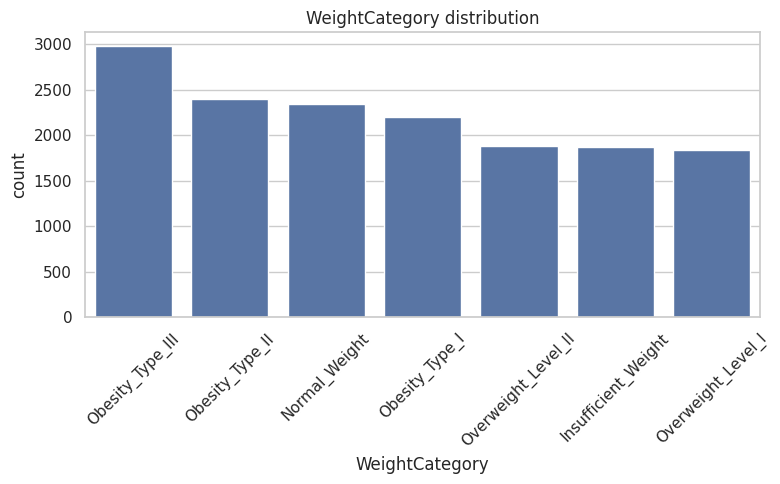

In [6]:
# %% [markdown]
# ## 2) Target Distribution

# %%
print('\n-- Target counts & proportions --')
print(train['WeightCategory'].value_counts())
print(train['WeightCategory'].value_counts(normalize=True))

plt.figure(figsize=(8,5))
sns.countplot(data=train, x='WeightCategory', order=train['WeightCategory'].value_counts().index)
plt.xticks(rotation=45)
plt.title('WeightCategory distribution')
plt.tight_layout()
plt.savefig('outputs/eda_target_distribution.png')
plt.show()


In [7]:
# %% [markdown]
# ## 3) BMI Feature

# %%
if 'BMI' not in train.columns and {'Weight','Height'}.issubset(train.columns):
    train['BMI'] = train['Weight'] / (train['Height']**2)
    test['BMI'] = test['Weight'] / (test['Height']**2) if {'Weight','Height'}.issubset(test.columns) else np.nan

print('\n-- BMI summary --')
print(train['BMI'].describe())



-- BMI summary --
count    15533.000000
mean        30.214076
std          8.314810
min         12.868541
25%         24.088223
50%         29.384757
75%         36.962959
max         54.997991
Name: BMI, dtype: float64


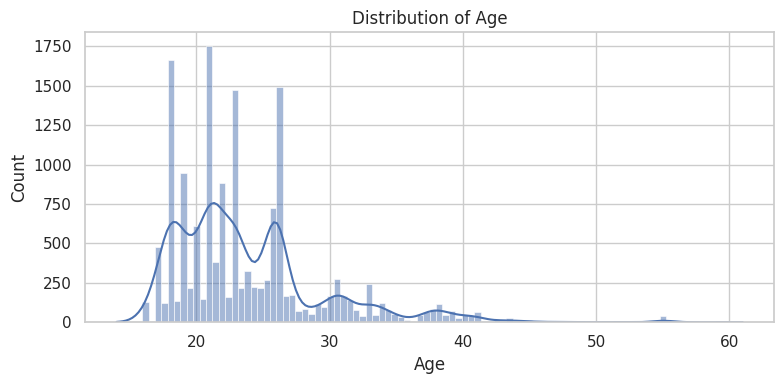

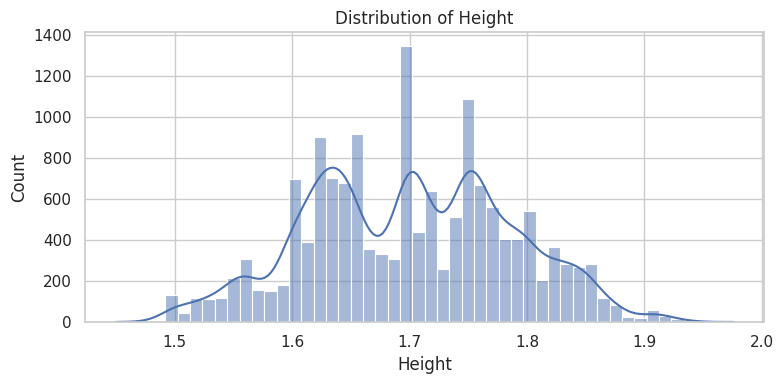

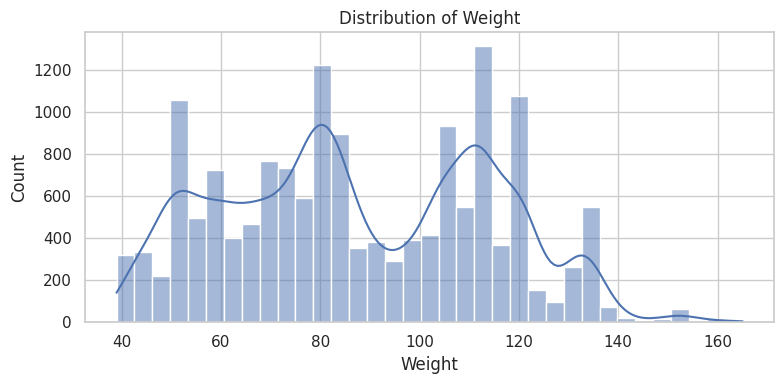

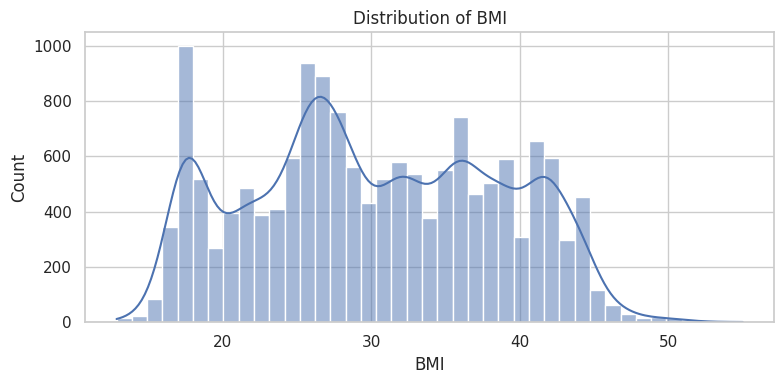

In [8]:
# %% [markdown]
# ## 4) Numerical Feature Distributions

# %%
num_feats = ['Age','Height','Weight','BMI']
for col in num_feats:
    if col in train.columns:
        plt.figure(figsize=(8,4))
        sns.histplot(train[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.savefig(f'outputs/eda_hist_{col}.png')
        plt.show()


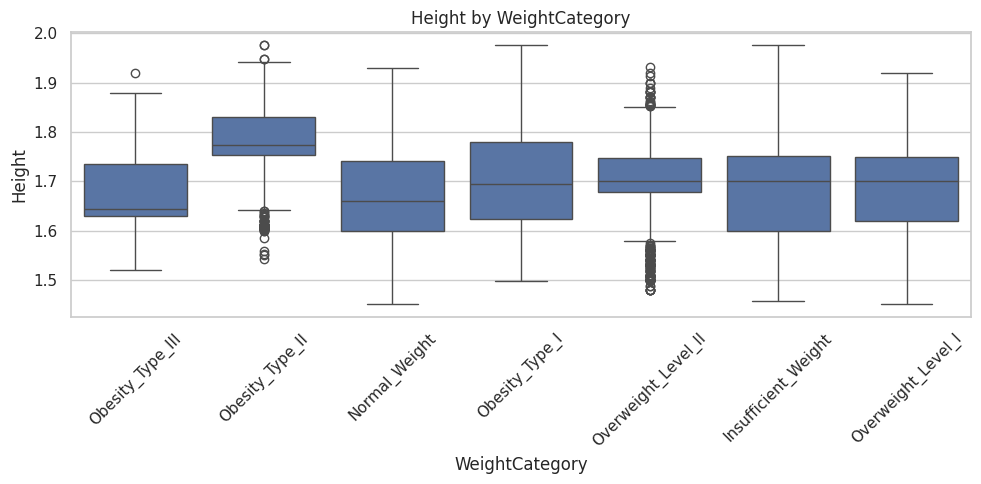

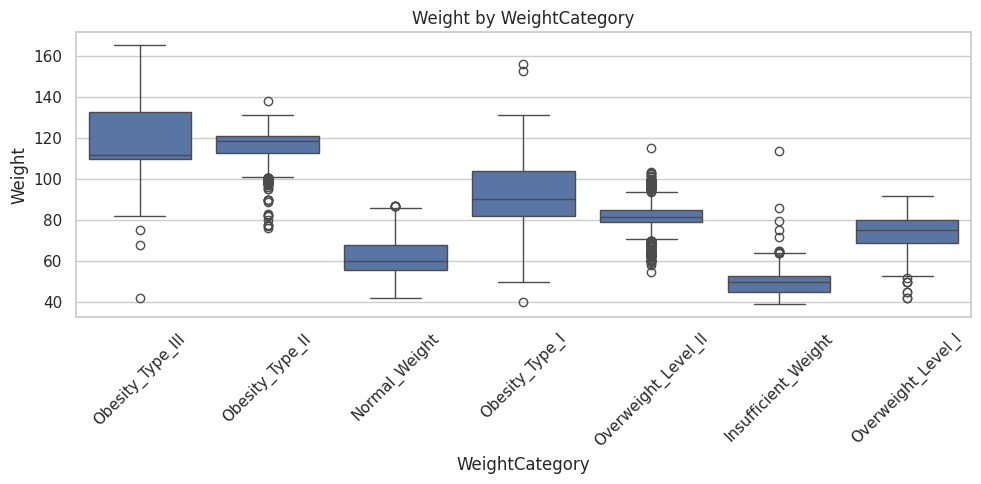

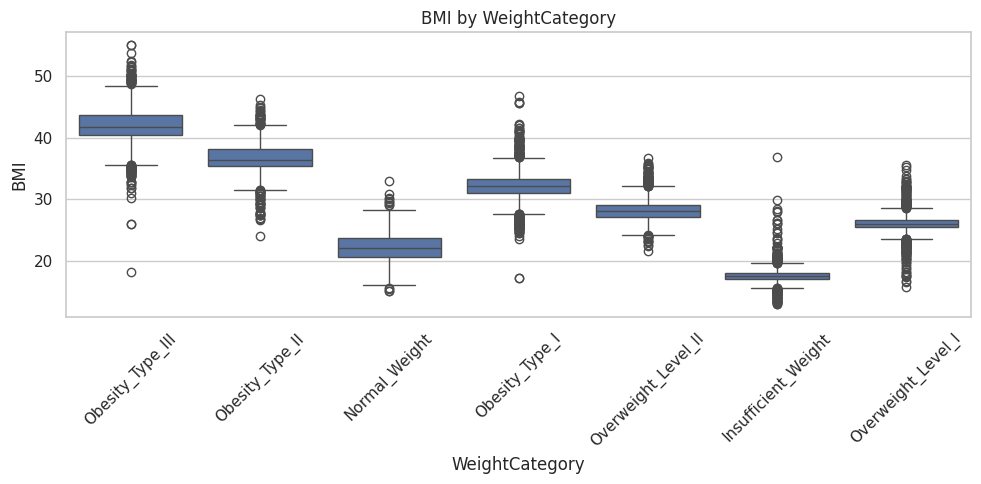

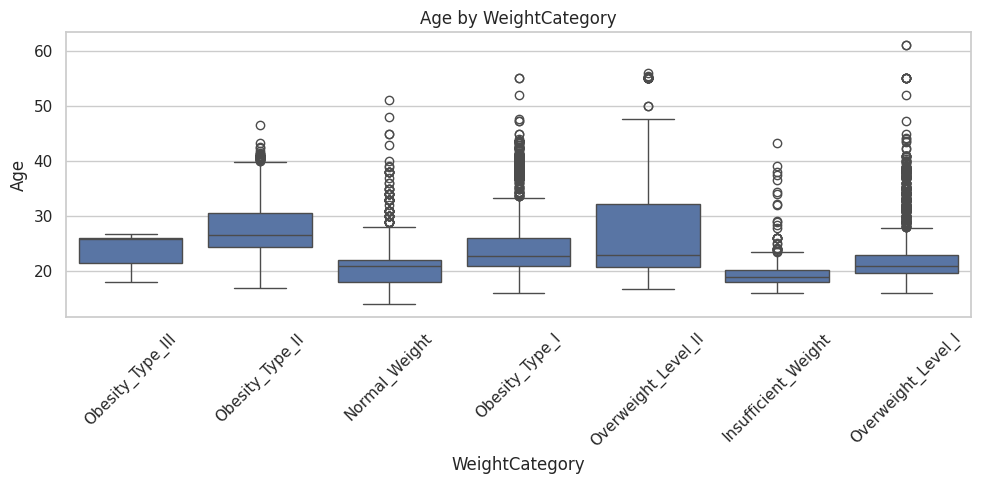

In [9]:
# %% [markdown]
# ## 5) Boxplots by WeightCategory

# %%
for col in ['Height','Weight','BMI','Age']:
    if col in train.columns:
        plt.figure(figsize=(10,5))
        sns.boxplot(x='WeightCategory', y=col, data=train, order=train['WeightCategory'].value_counts().index)
        plt.xticks(rotation=45)
        plt.title(f'{col} by WeightCategory')
        plt.tight_layout()
        plt.savefig(f'outputs/eda_box_{col}.png')
        plt.show()


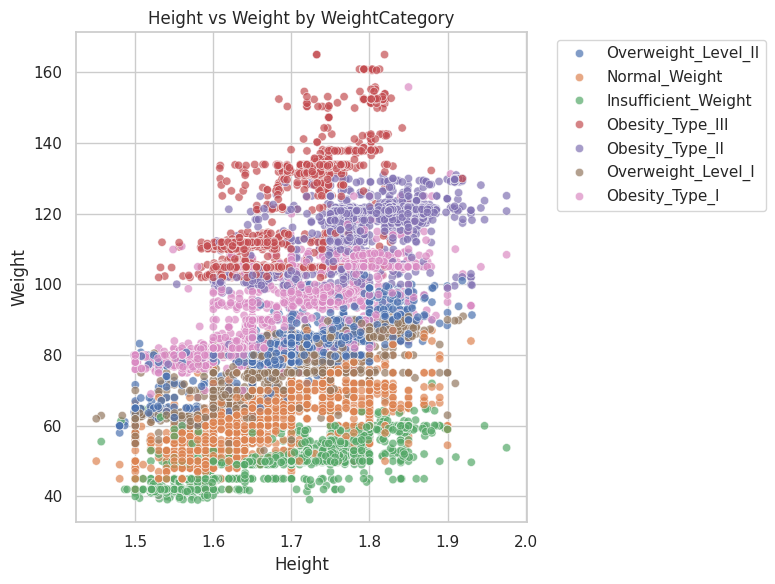

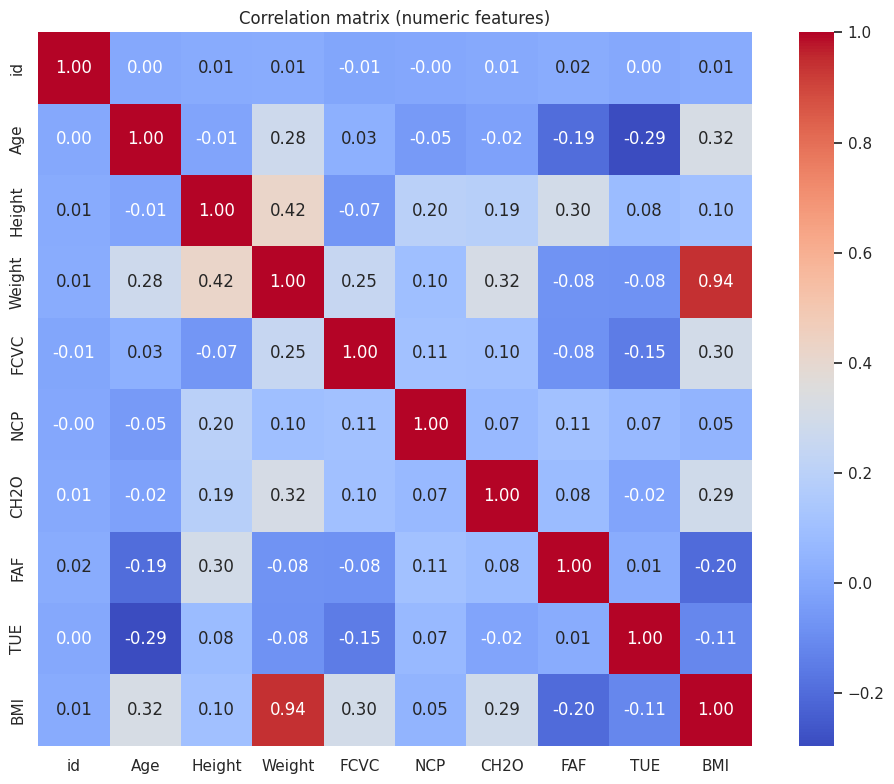

In [10]:
# %% [markdown]
# ## 6) Height vs Weight Scatter & Correlation

# %%
if set(['Height','Weight','WeightCategory']).issubset(train.columns):
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=train, x='Height', y='Weight', hue='WeightCategory', alpha=0.7)
    plt.title('Height vs Weight by WeightCategory')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('outputs/eda_scatter_height_weight.png')
    plt.show()

num_for_corr = train.select_dtypes(include=[np.number]).columns.tolist()
if len(num_for_corr) > 1:
    corr = train[num_for_corr].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title('Correlation matrix (numeric features)')
    plt.tight_layout()
    plt.savefig('outputs/eda_corr_heatmap.png')
    plt.show()


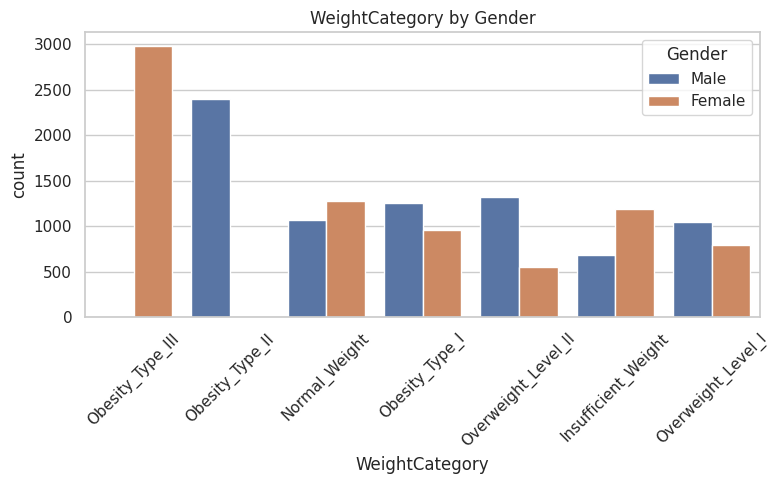

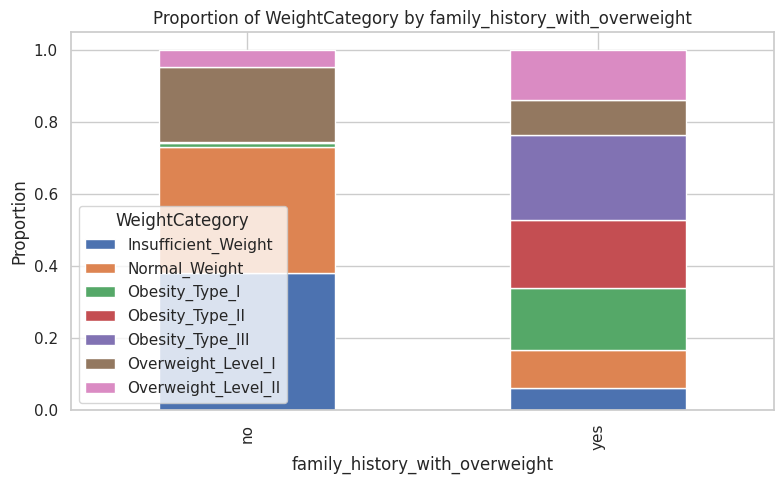

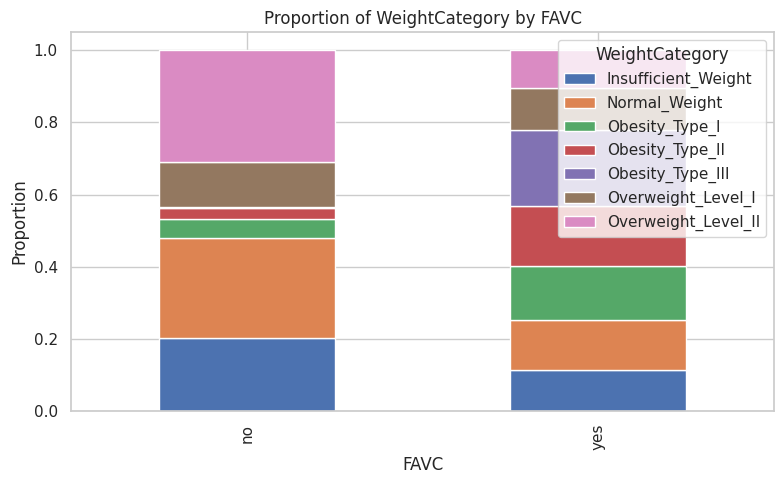

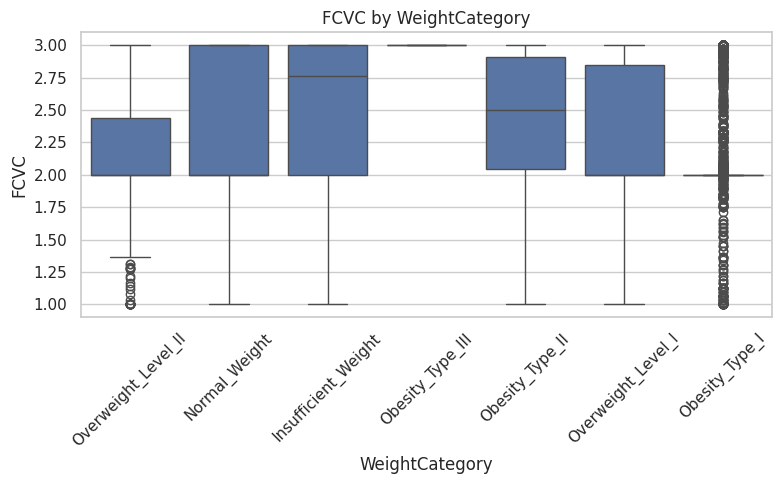

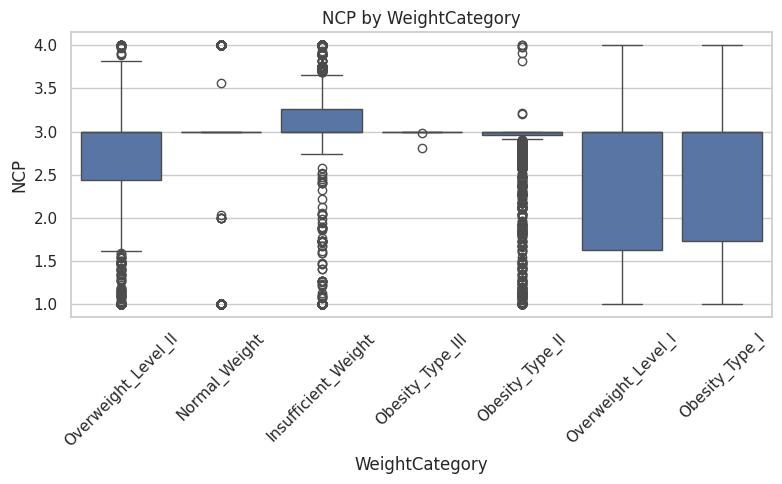

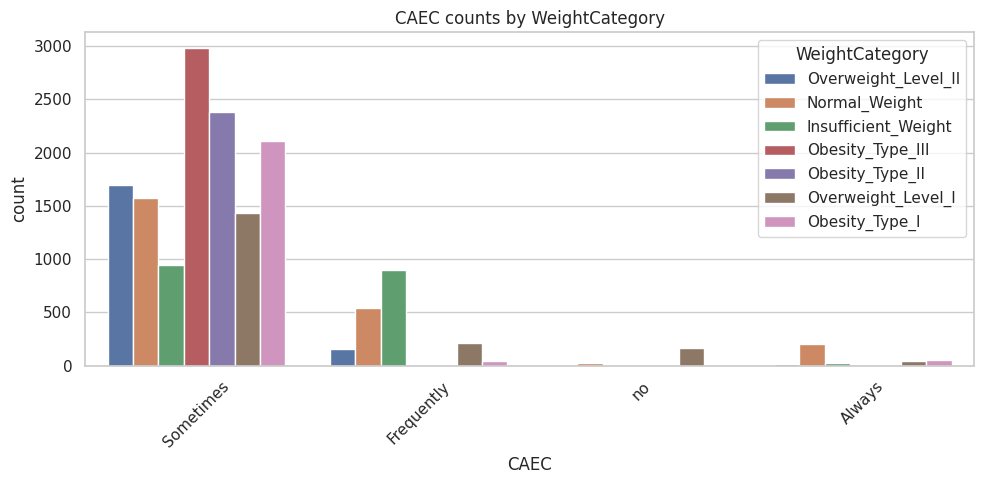

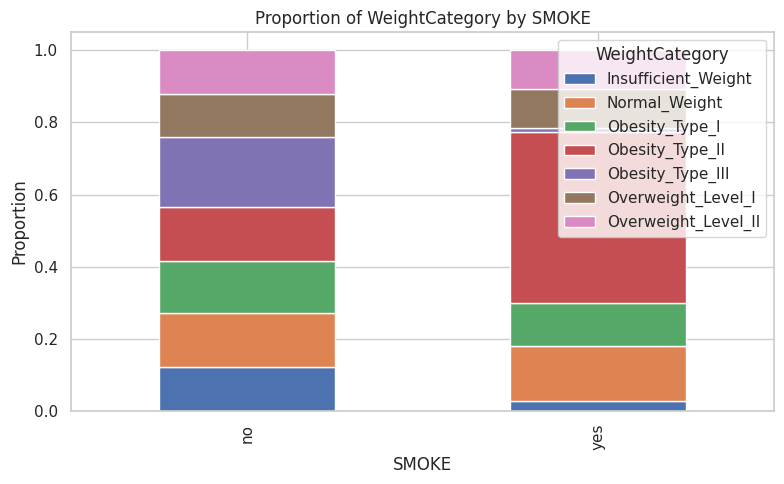

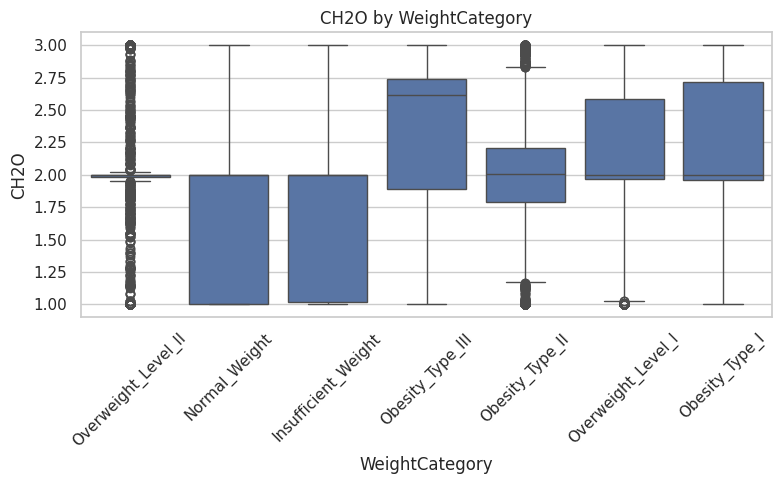

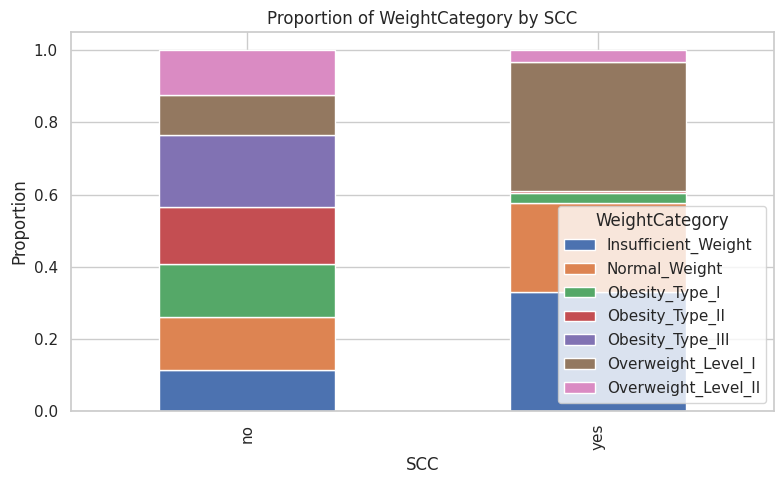

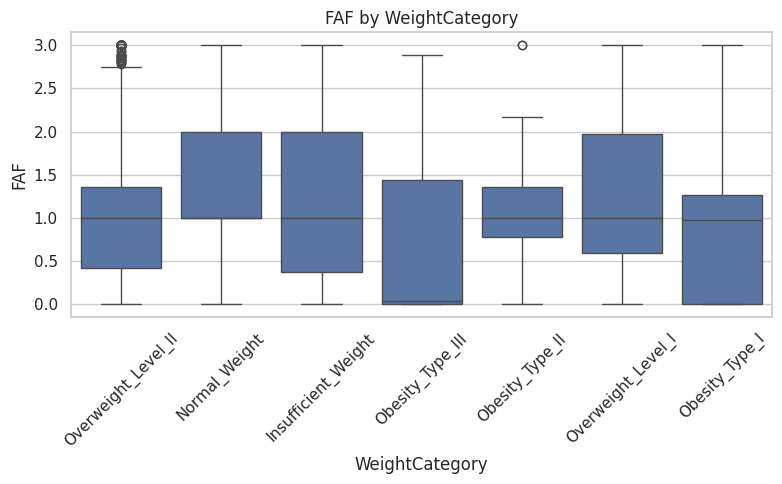

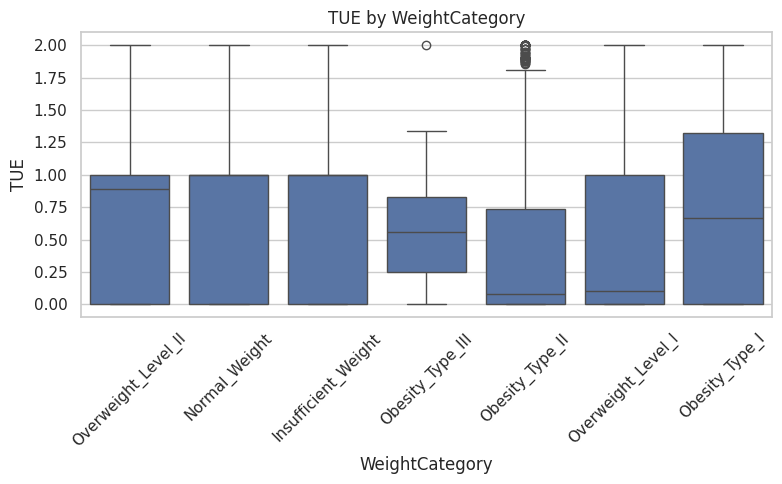

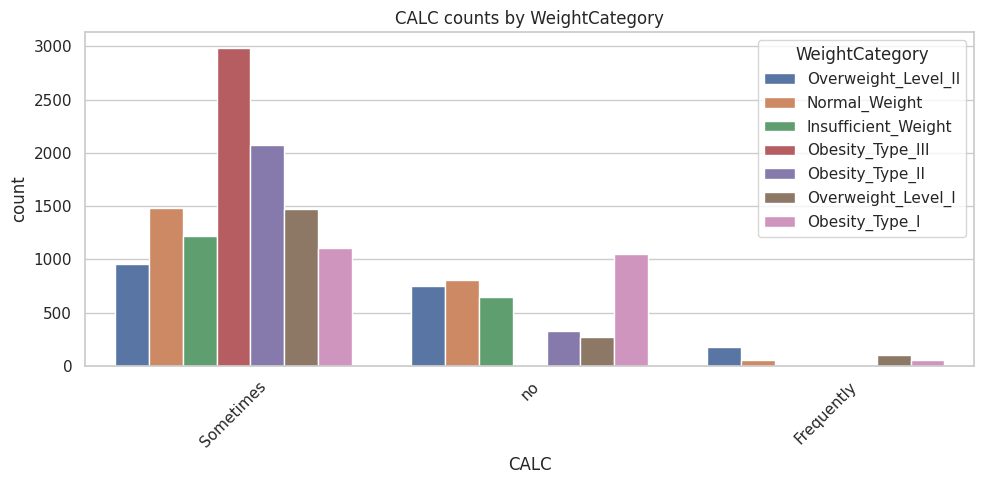

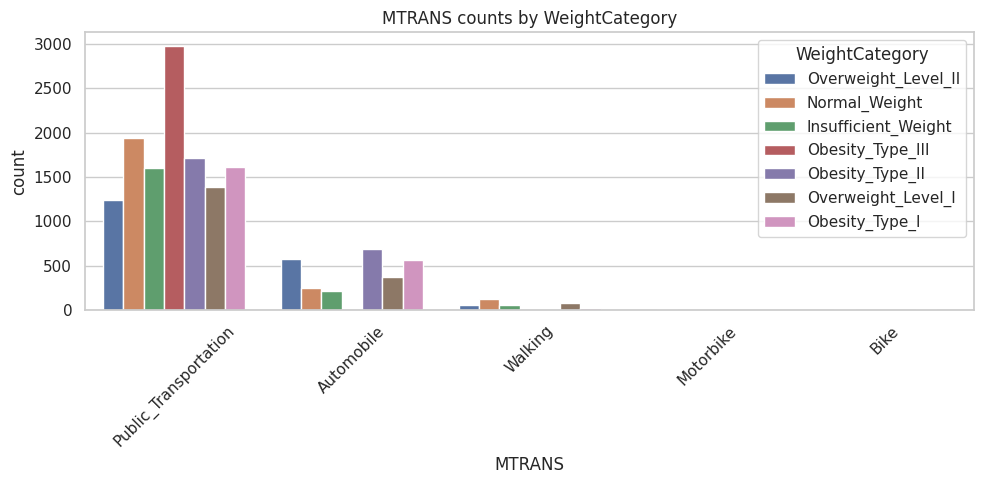

In [11]:
# %% [markdown]
# ## 7) Gender & Lifestyle Analysis

# %%
if 'Gender' in train.columns:
    plt.figure(figsize=(8,5))
    sns.countplot(data=train, x='WeightCategory', hue='Gender', order=train['WeightCategory'].value_counts().index)
    plt.xticks(rotation=45)
    plt.title('WeightCategory by Gender')
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.savefig('outputs/eda_gender_category.png')
    plt.show()

lifestyle_cols = ['family_history_with_overweight','FAVC','FCVC','NCP','CAEC','SMOKE','CH2O','SCC','FAF','TUE','CALC','MTRANS']
present_lifestyle = [c for c in lifestyle_cols if c in train.columns]
binary_like = ['family_history_with_overweight','FAVC','SMOKE','SCC']

for c in present_lifestyle:
    if c in binary_like:
        ct = pd.crosstab(train[c], train['WeightCategory'], normalize='index')
        ct.plot(kind='bar', stacked=True, figsize=(8,5))
        plt.title(f'Proportion of WeightCategory by {c}')
        plt.ylabel('Proportion')
        plt.tight_layout()
        plt.savefig(f'outputs/eda_lifestyle_{c}.png')
        plt.show()
    elif train[c].dtype == object or train[c].dtype.name == 'category':
        plt.figure(figsize=(10,5))
        sns.countplot(data=train, x=c, hue='WeightCategory')
        plt.xticks(rotation=45)
        plt.title(f'{c} counts by WeightCategory')
        plt.tight_layout()
        plt.savefig(f'outputs/eda_lifestyle_{c}.png')
        plt.show()
    else:
        plt.figure(figsize=(8,5))
        sns.boxplot(x='WeightCategory', y=c, data=train)
        plt.xticks(rotation=45)
        plt.title(f'{c} by WeightCategory')
        plt.tight_layout()
        plt.savefig(f'outputs/eda_lifestyle_{c}.png')
        plt.show()


In [12]:
# %% [markdown]
# ## 8) Chi-Square Tests

# %%
cat_features = [c for c in train.columns if train[c].dtype == 'object' and c != 'WeightCategory']
chi2_results = []
for c in cat_features:
    try:
        contingency = pd.crosstab(train[c], train['WeightCategory'])
        chi2, p, dof, ex = chi2_contingency(contingency)
        chi2_results.append({'feature': c, 'chi2': chi2, 'p_value': p})
    except:
        chi2_results.append({'feature': c, 'chi2': np.nan, 'p_value': np.nan})

chi2_df = pd.DataFrame(chi2_results).sort_values('p_value')
chi2_df.to_csv('outputs/eda_chi2_results.csv', index=False)


In [13]:
# %% [markdown]
# ## 9) Save EDA Insights

# %%
insights = []
value_counts = train['WeightCategory'].value_counts(normalize=True)
insights.append(f"Target distribution (proportions): {value_counts.to_dict()}")

if 'BMI' in train.columns:
    grp = train.groupby('WeightCategory')['BMI'].median().sort_values()
    insights.append('Median BMI by class: ' + '; '.join([f"{i}: {v:.2f}" for i,v in grp.items()]))

if 'Gender' in train.columns:
    pct = pd.crosstab(train['Gender'], train['WeightCategory'], normalize='index')
    insights.append('Gender vs WeightCategory proportions: ' + pct.to_string())

with open('outputs/eda_insights.txt','w') as f:
    f.write('\n'.join(insights))

print('EDA visuals and summary saved to outputs/ (png, csv, txt)')


EDA visuals and summary saved to outputs/ (png, csv, txt)


In [14]:
# ## 3) Preprocessing
# We'll build a reproducible pipeline:
# - SimpleImputer (median for numerics, most_frequent for categoricals)
# - Encode categoricals as integer codes (consistent between train/test)
# - Scale numeric features for KNN


# %%
TARGET = 'WeightCategory'
ID_COL = 'id' if 'id' in train.columns else None


# Separate X/y
y = train[TARGET].copy()
X = train.drop(columns=[TARGET])
X_test = test.copy()

In [40]:
X.shape

(15533, 18)

In [15]:
# Identify column types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
if ID_COL and ID_COL in num_cols:
  num_cols.remove(ID_COL)
if ID_COL and ID_COL in cat_cols:
  cat_cols.remove(ID_COL)


print('Numeric cols:', len(num_cols))
print('Categorical cols:', len(cat_cols))

Numeric cols: 9
Categorical cols: 8


In [16]:
# %%
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='passthrough')

preprocessor.fit(X)


ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Height', 'Weight', 'FCVC', 'NCP',
                                  'CH2O', 'FAF', 'TUE', 'BMI']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['Gender', 'family_history_with_overweight',
                                  'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC',
                                  'MTRANS'])])

In [17]:
# %%
# Transform numeric and categorical separately for clearer handling
X_num = preprocessor.named_transformers_['num'].transform(X[num_cols])
X_test_num = preprocessor.named_transformers_['num'].transform(X_test[num_cols])

cat_imputer = preprocessor.named_transformers_['cat'].named_steps['imputer']
X_cat_imputed = cat_imputer.transform(X[cat_cols]) if cat_cols else np.empty((len(X),0))
X_test_cat_imputed = cat_imputer.transform(X_test[cat_cols]) if cat_cols else np.empty((len(X_test),0))

df_num = pd.DataFrame(X_num, columns=[f'num_{c}' for c in num_cols], index=X.index)
df_test_num = pd.DataFrame(X_test_num, columns=[f'num_{c}' for c in num_cols], index=X_test.index)

if cat_cols:
    df_cat = pd.DataFrame(X_cat_imputed, columns=cat_cols, index=X.index)
    df_test_cat = pd.DataFrame(X_test_cat_imputed, columns=cat_cols, index=X_test.index)

    combined = pd.concat([df_cat, df_test_cat], axis=0)
    for c in cat_cols:
        combined[c] = combined[c].astype('category').cat.codes

    df_cat_encoded = combined.iloc[:len(df_cat)].reset_index(drop=True)
    df_test_cat_encoded = combined.iloc[len(df_cat):].reset_index(drop=True)
else:
    df_cat_encoded = pd.DataFrame(index=X.index)
    df_test_cat_encoded = pd.DataFrame(index=X_test.index)

X_processed = pd.concat([df_num.reset_index(drop=True), df_cat_encoded.reset_index(drop=True)], axis=1)
X_test_processed = pd.concat([df_test_num.reset_index(drop=True), df_test_cat_encoded.reset_index(drop=True)], axis=1)

print('\nProcessed X shape:', X_processed.shape)
print('Processed X_test shape:', X_test_processed.shape)



Processed X shape: (15533, 17)
Processed X_test shape: (5225, 17)


In [18]:
# %% [markdown]
# Encode target labels


In [19]:
# %%
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print('\nClasses:', le.classes_)
joblib.dump(le, 'models/label_encoder.joblib')



Classes: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


['models/label_encoder.joblib']

In [20]:
# %% [markdown]
# ## 4) Train/validation split


In [21]:
X_train_hold, X_valid_hold, y_train_hold, y_valid_hold = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=RNG, stratify=y_encoded
)
print('Hold-out train:', X_train_hold.shape, 'Valid:', X_valid_hold.shape)


Hold-out train: (12426, 17) Valid: (3107, 17)


In [22]:
# %% [markdown]
# ## 5) Evaluate model helper


In [23]:
# %%
def evaluate_model(model, X_val, y_val, model_name='Model'):
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"{model_name} Accuracy: {acc*100:.2f}%")
    print('\nClassification report:')
    print(classification_report(y_val, preds, target_names=le.classes_))
    cm = confusion_matrix(y_val, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, xticks_rotation='vertical')
    plt.title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f'outputs/{model_name}_confusion_matrix.png')
    plt.show()
    return acc, cm


In [24]:
# %% [markdown]
# ## 6) Baseline models


KNN Accuracy: 78.50%

Classification report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.79      0.86      0.82       374
      Normal_Weight       0.65      0.66      0.66       469
     Obesity_Type_I       0.74      0.78      0.76       441
    Obesity_Type_II       0.91      0.95      0.93       481
   Obesity_Type_III       0.99      1.00      0.99       597
 Overweight_Level_I       0.59      0.51      0.55       369
Overweight_Level_II       0.66      0.60      0.63       376

           accuracy                           0.79      3107
          macro avg       0.76      0.76      0.76      3107
       weighted avg       0.78      0.79      0.78      3107



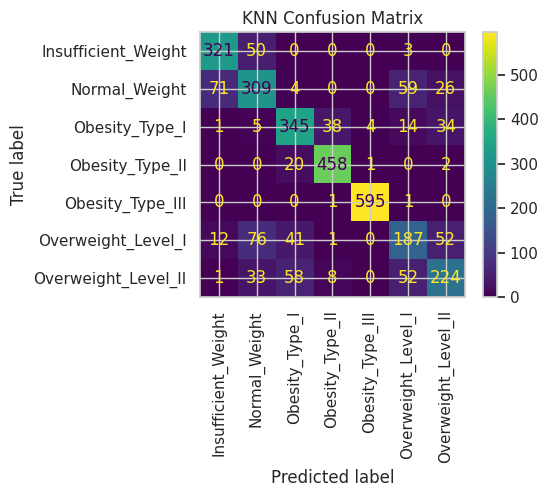

DecisionTree Accuracy: 84.07%

Classification report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.88      0.88       374
      Normal_Weight       0.79      0.79      0.79       469
     Obesity_Type_I       0.82      0.79      0.81       441
    Obesity_Type_II       0.94      0.94      0.94       481
   Obesity_Type_III       0.99      0.99      0.99       597
 Overweight_Level_I       0.65      0.65      0.65       369
Overweight_Level_II       0.71      0.73      0.72       376

           accuracy                           0.84      3107
          macro avg       0.83      0.83      0.83      3107
       weighted avg       0.84      0.84      0.84      3107



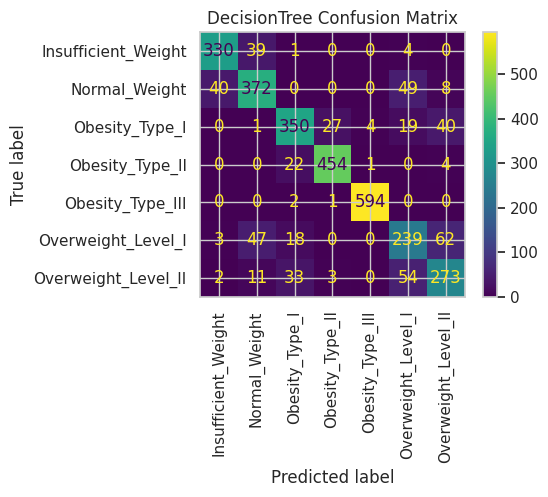

RandomForest Accuracy: 90.09%

Classification report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.95      0.94       374
      Normal_Weight       0.88      0.90      0.89       469
     Obesity_Type_I       0.88      0.86      0.87       441
    Obesity_Type_II       0.96      0.98      0.97       481
   Obesity_Type_III       0.99      1.00      0.99       597
 Overweight_Level_I       0.80      0.73      0.77       369
Overweight_Level_II       0.79      0.82      0.81       376

           accuracy                           0.90      3107
          macro avg       0.89      0.89      0.89      3107
       weighted avg       0.90      0.90      0.90      3107



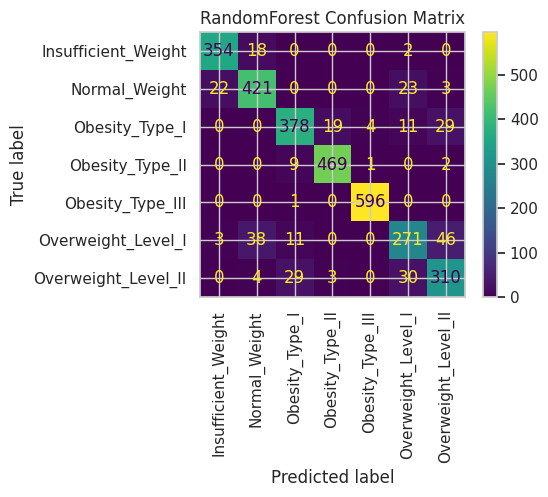

In [25]:
# KNN
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_hold, y_train_hold)
joblib.dump(knn, 'models/knn_base.joblib')
knn_acc, knn_cm = evaluate_model(knn, X_valid_hold, y_valid_hold, 'KNN')

# Decision Tree
dt = DecisionTreeClassifier(random_state=RNG)
dt.fit(X_train_hold, y_train_hold)
joblib.dump(dt, 'models/decision_tree_base.joblib')
dt_acc, dt_cm = evaluate_model(dt, X_valid_hold, y_valid_hold, 'DecisionTree')

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=RNG, n_jobs=-1)
rf.fit(X_train_hold, y_train_hold)
joblib.dump(rf, 'models/random_forest_base.joblib')
rf_acc, rf_cm = evaluate_model(rf, X_valid_hold, y_valid_hold, 'RandomForest')

# Save baseline results
baseline_results = pd.DataFrame({
    'model': ['KNN','DecisionTree','RandomForest'],
    'accuracy': [knn_acc, dt_acc, rf_acc]
})
baseline_results.to_csv('outputs/baseline_results.csv', index=False)


In [26]:
# %% [markdown]
# ## 7) Cross-validated OOF predictions (optional)



Running OOF for KNN
KNN OOF Accuracy: 79.08%


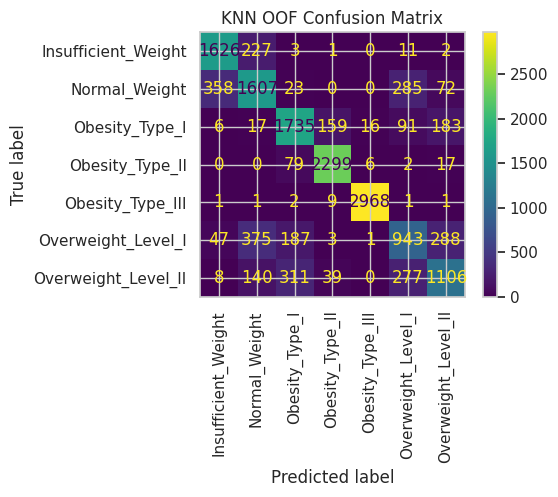


Running OOF for DecisionTree
DecisionTree OOF Accuracy: 83.83%


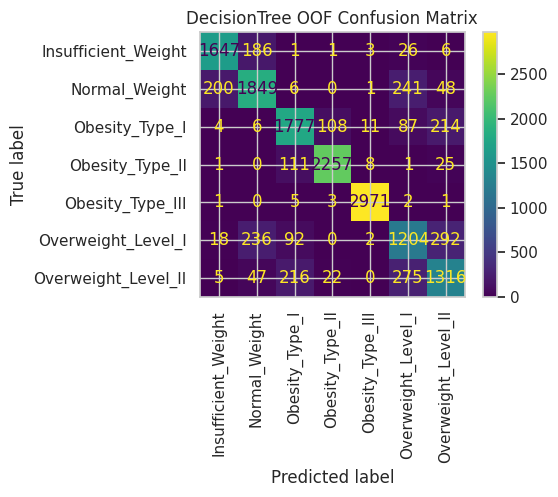


Running OOF for RandomForest
RandomForest OOF Accuracy: 89.84%


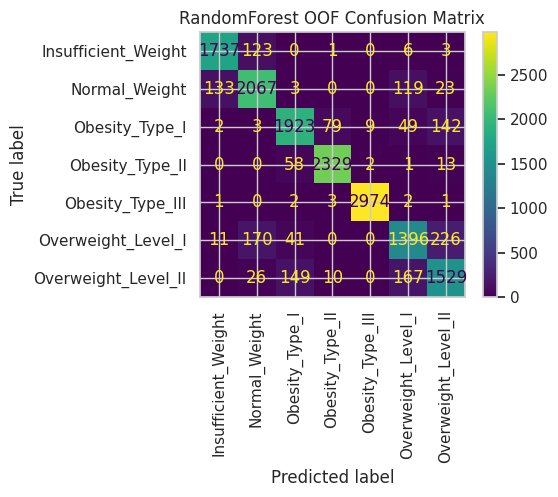

In [27]:
# %%
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

models = {
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'DecisionTree': DecisionTreeClassifier(random_state=RNG),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RNG, n_jobs=-1)
}

oof_results = []
for name, model in models.items():
    print('\nRunning OOF for', name)
    oof_preds = cross_val_predict(model, X_processed, y_encoded, cv=skf, method='predict', n_jobs=-1)
    acc = accuracy_score(y_encoded, oof_preds)
    print(f'{name} OOF Accuracy: {acc*100:.2f}%')
    cm = confusion_matrix(y_encoded, oof_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, xticks_rotation='vertical')
    plt.title(f'{name} OOF Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f'outputs/{name}_oof_cm.png')
    plt.show()
    oof_results.append({'model': name, 'oof_accuracy': acc})

pd.DataFrame(oof_results).to_csv('outputs/oof_results.csv', index=False)


In [28]:
# %% [markdown]
# ## 8) XGBoost ensemble with Optuna tuning


In [29]:
# %%
X_for_xgb = X_processed.copy()
X_test_for_xgb = X_test_processed.copy()


In [30]:
# %%
def objective(trial):
    params = {
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y_encoded)),
        'eval_metric': 'mlogloss',
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 2.0),
        'seed': RNG,
        'verbosity': 0
    }
    cv_acc = []
    for train_idx, val_idx in skf.split(X_for_xgb, y_encoded):
        X_train, X_val = X_for_xgb.iloc[train_idx], X_for_xgb.iloc[val_idx]
        y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        bst = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=400,
            evals=[(dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        preds = bst.predict(dval)
        cv_acc.append(accuracy_score(y_val, preds.argmax(axis=1)))
    return np.mean(cv_acc)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, show_progress_bar=True)
best_params = study.best_params
best_params.update({'objective': 'multi:softprob','num_class': len(np.unique(y_encoded)),'eval_metric': 'mlogloss','verbosity':0})


[I 2025-10-26 14:38:28,201] A new study created in memory with name: no-name-58986d19-3bd4-419e-8cb5-0b5fd7fc0dda


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-10-26 14:39:01,633] Trial 0 finished with value: 0.8946764580985833 and parameters: {'max_depth': 5, 'learning_rate': 0.013571837404056129, 'subsample': 0.96231801621552, 'colsample_bytree': 0.8635683626489091, 'min_child_weight': 7, 'gamma': 0.1404347990287101, 'reg_alpha': 0.1443942628064525, 'reg_lambda': 0.7944977518343834}. Best is trial 0 with value: 0.8946764580985833.
[I 2025-10-26 14:39:31,737] Trial 1 finished with value: 0.8968009423914717 and parameters: {'max_depth': 5, 'learning_rate': 0.016799807512210614, 'subsample': 0.8956147736766631, 'colsample_bytree': 0.919171582623973, 'min_child_weight': 2, 'gamma': 0.4556792441724166, 'reg_alpha': 0.2774930740051569, 'reg_lambda': 1.549449095499475}. Best is trial 1 with value: 0.8968009423914717.
[I 2025-10-26 14:39:43,674] Trial 2 finished with value: 0.9033028674009689 and parameters: {'max_depth': 4, 'learning_rate': 0.17340557087162636, 'subsample': 0.848671495581899, 'colsample_bytree': 0.7669038395850871, 'min_ch

In [31]:
# %%
# Ensemble training
ensemble_size = 5
n_classes = len(np.unique(y_encoded))
test_pred_prob = np.zeros((len(X_test_for_xgb), n_classes))
oof_preds = np.zeros((len(X_for_xgb), n_classes))

for model_num in range(ensemble_size):
    print(f'\nTraining XGBoost Model {model_num+1}/{ensemble_size}')
    model_seed = RNG + model_num
    best_params['seed'] = int(model_seed)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_for_xgb, y_encoded)):
        print(f' Fold {fold+1}')
        X_train, X_val = X_for_xgb.iloc[train_idx], X_for_xgb.iloc[val_idx]
        y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(X_test_for_xgb)

        bst = xgb.train(
            params=best_params,
            dtrain=dtrain,
            num_boost_round=1000,
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=100,
            verbose_eval=100
        )

        best_iter = bst.best_iteration or 1000

        oof_preds[val_idx] += bst.predict(dval, iteration_range=(0, best_iter)) / ensemble_size
        test_pred_prob += bst.predict(dtest, iteration_range=(0, best_iter)) / (skf.n_splits * ensemble_size)

oof_pred_labels = oof_preds.argmax(axis=1)
cv_acc = accuracy_score(y_encoded, oof_pred_labels)
print(f'Final OOF CV Accuracy (Ensemble): {cv_acc*100:.2f}%')

pd.DataFrame(oof_preds, columns=le.classes_).to_csv('outputs/xgb_oof_probs.csv', index=False)
pd.DataFrame(test_pred_prob, columns=le.classes_).to_csv('outputs/xgb_test_probs.csv', index=False)



Training XGBoost Model 1/5
 Fold 1
[0]	train-mlogloss:1.87884	eval-mlogloss:1.88011
[100]	train-mlogloss:0.38912	eval-mlogloss:0.44967
[200]	train-mlogloss:0.22697	eval-mlogloss:0.32027
[300]	train-mlogloss:0.17999	eval-mlogloss:0.29686
[400]	train-mlogloss:0.15418	eval-mlogloss:0.29136
[500]	train-mlogloss:0.13635	eval-mlogloss:0.29104
[554]	train-mlogloss:0.12866	eval-mlogloss:0.29155
 Fold 2
[0]	train-mlogloss:1.87875	eval-mlogloss:1.87987
[100]	train-mlogloss:0.39187	eval-mlogloss:0.44135
[200]	train-mlogloss:0.22982	eval-mlogloss:0.30687
[300]	train-mlogloss:0.18258	eval-mlogloss:0.28034
[400]	train-mlogloss:0.15683	eval-mlogloss:0.27294
[500]	train-mlogloss:0.13922	eval-mlogloss:0.27120
[600]	train-mlogloss:0.12585	eval-mlogloss:0.27160
[630]	train-mlogloss:0.12259	eval-mlogloss:0.27179
 Fold 3
[0]	train-mlogloss:1.87868	eval-mlogloss:1.87998
[100]	train-mlogloss:0.39061	eval-mlogloss:0.44796
[200]	train-mlogloss:0.22898	eval-mlogloss:0.31559
[300]	train-mlogloss:0.18098	eval-ml

In [32]:
# %% [markdown]
# ## 9) Create final submission


In [33]:
# %%
if 'id' in test.columns:
    submission = pd.DataFrame({'id': test['id'], TARGET: le.inverse_transform(test_pred_prob.argmax(axis=1))})
    submission.to_csv('outputs/submission_ensemble.csv', index=False)
    print('Submission saved to outputs/submission_ensemble.csv')
else:
    print('No id column in test; skipping submission save.')


Submission saved to outputs/submission_ensemble.csv


In [34]:
# %% [markdown]
# ## 10) Save summary results for report


In [35]:
# %%
summary = {
    'baseline': baseline_results,
    'oof_results': pd.DataFrame(oof_results),
    'xgb_oof_accuracy': cv_acc
}

with open('outputs/summary.txt', 'w') as f:
    f.write('Baseline results:\n')
    f.write(baseline_results.to_string(index=False))
    f.write('\n\nOOF results:\n')
    f.write(pd.DataFrame(oof_results).to_string(index=False))
    f.write('\n\nXGBoost OOF accuracy: {:.4f}\n'.format(cv_acc))

print('Summary saved to outputs/summary.txt')


Summary saved to outputs/summary.txt


In [38]:
# SUBMISSION.CSV

# import pandas as pd
# import numpy as np
# import xgboost as xgb
# import optuna
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score

# # =============================
# # 1) Load data
# # =============================
# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

# target_col = "WeightCategory"
# y = train[target_col]
# X = train.drop(columns=[target_col])
# test_ids = test["id"]
# X_test = test.copy()

# # =============================
# # 2) Encode features
# # =============================
# for df in [X, X_test]:
#     # Convert boolean columns to integers
#     bool_cols = df.select_dtypes(include="bool").columns
#     df[bool_cols] = df[bool_cols].astype(int)

#     # Encode categorical columns
#     cat_cols = df.select_dtypes(include="object").columns
#     for c in cat_cols:
#         df[c] = df[c].astype("category").cat.codes

# # =============================
# # 3) Encode target
# # =============================
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# # =============================
# # 4) Stratified K-Fold setup
# # =============================
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # =============================
# # 5) Optuna tuning
# # =============================
# def objective(trial):
#     params = {
#         "objective": "multi:softprob",
#         "num_class": len(np.unique(y_encoded)),
#         "eval_metric": "mlogloss",
#         "max_depth": trial.suggest_int("max_depth", 4, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#         "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
#         "gamma": trial.suggest_float("gamma", 0.0, 0.5),
#         "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
#         "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2.0),
#         "seed": 42,
#     }

#     cv_acc = []
#     for train_idx, val_idx in skf.split(X, y_encoded):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

#         dtrain = xgb.DMatrix(X_train, label=y_train)
#         dval = xgb.DMatrix(X_val, label=y_val)

#         bst = xgb.train(
#             params=params,
#             dtrain=dtrain,
#             num_boost_round=400,
#             evals=[(dval, "eval")],
#             early_stopping_rounds=50,
#             verbose_eval=False
#         )

#         preds = bst.predict(dval)
#         cv_acc.append(accuracy_score(y_val, preds.argmax(axis=1)))

#     return np.mean(cv_acc)

# # =============================
# # 6) Run Optuna tuning
# # =============================
# print("🔍 Running Optuna tuning (15 trials)...")
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=15, show_progress_bar=True)

# best_params = study.best_params
# best_params.update({
#     "objective": "multi:softprob",
#     "num_class": len(np.unique(y_encoded)),
#     "eval_metric": "mlogloss"
# })

# print("\n✅ Best params:", best_params)

# # =============================
# # 7) Ensemble of XGBoosts
# # =============================
# ensemble_size = 5  # Number of XGBoost models in the ensemble

# test_pred_prob = np.zeros((len(X_test), len(np.unique(y_encoded))))
# oof_preds = np.zeros((len(X), len(np.unique(y_encoded))))

# for model_num in range(ensemble_size):
#     print(f"\n===== Training XGBoost Model {model_num + 1}/{ensemble_size} =====")
#     model_seed = 42 + model_num  # Different seed for each model
#     best_params["seed"] = model_seed

#     for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded)):
#         print(f"--- Fold {fold + 1}/5 ---")
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

#         dtrain = xgb.DMatrix(X_train, label=y_train)
#         dval = xgb.DMatrix(X_val, label=y_val)
#         dtest = xgb.DMatrix(X_test)

#         bst = xgb.train(
#             params=best_params,
#             dtrain=dtrain,
#             num_boost_round=1000,
#             evals=[(dtrain, "train"), (dval, "eval")],
#             early_stopping_rounds=100,
#             verbose_eval=100
#         )

#         best_iter = bst.best_iteration or 1000

#         # Store OOF predictions
#         oof_preds[val_idx] += bst.predict(dval, iteration_range=(0, best_iter)) / ensemble_size

#         # Store test predictions
#         test_pred_prob += bst.predict(dtest, iteration_range=(0, best_iter)) / (skf.n_splits * ensemble_size)

# # =============================
# # 8) Evaluate OOF Accuracy
# # =============================
# oof_pred_labels = oof_preds.argmax(axis=1)
# cv_acc = accuracy_score(y_encoded, oof_pred_labels)
# print(f"\n🏁 Final OOF CV Accuracy (Ensemble): {cv_acc * 100:.2f}%")

# # =============================
# # 9) Save submission
# # =============================
# y_test_pred = test_pred_prob.argmax(axis=1)
# y_test_labels = le.inverse_transform(y_test_pred)

# submission = pd.DataFrame({
#     "id": test_ids,
#     "WeightCategory": y_test_labels
# })
# submission.to_csv("submission_ensemble.csv", index=False)
# print("\n✅ submission_ensemble.csv saved successfully!")


In [44]:
!zip -r output.zip /content/outputs

  adding: content/outputs/ (stored 0%)
  adding: content/outputs/eda_box_BMI.png (deflated 13%)
  adding: content/outputs/eda_gender_category.png (deflated 15%)
  adding: content/outputs/eda_corr_heatmap.png (deflated 7%)
  adding: content/outputs/xgb_oof_probs.csv (deflated 56%)
  adding: content/outputs/eda_lifestyle_CALC.png (deflated 14%)
  adding: content/outputs/xgb_test_probs.csv (deflated 56%)
  adding: content/outputs/eda_hist_Height.png (deflated 9%)
  adding: content/outputs/eda_hist_Weight.png (deflated 8%)
  adding: content/outputs/RandomForest_oof_cm.png (deflated 7%)
  adding: content/outputs/eda_box_Height.png (deflated 13%)
  adding: content/outputs/eda_lifestyle_SCC.png (deflated 10%)
  adding: content/outputs/eda_target_distribution.png (deflated 15%)
  adding: content/outputs/baseline_results.csv (deflated 8%)
  adding: content/outputs/eda_box_Weight.png (deflated 13%)
  adding: content/outputs/eda_lifestyle_family_history_with_overweight.png (deflated 10%)
  adding